---
### 4. Retention 분석
- cohort, 잔존율 등 

---

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
import datetime as dt 
import koreanize_matplotlib

In [2]:
## dataset loading 
import pyarrow as pa
import pyarrow.parquet as pq 

df_valid = pd.read_parquet('data/df_valid.parquet', engine='pyarrow') 
print(df_valid.shape)
df_valid.head(2)

(392692, 20)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_price,isRegistered,InvoiceCode,isCancel,InvoiceYear,InvoiceMonth,InvoiceDay,InvoiceDow,InvoiceTime,InvoiceHour,InvoiceYM,InvoceDayName
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,True,,False,2010,12,1,2,08:26:00,8,2010-12,수
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,True,,False,2010,12,1,2,08:26:00,8,2010-12,수


---
### Monthly Cohort Index 만들기 
- 고객 개개인별로 가장 최근 구매일과 최초 구매일의 차이를 구한다. 
- 다년간의 자료이므로, index = (연도차이(year_diff) x 12) + (월차이(month_diff) +1)
---

In [28]:
## 고객별 최초 구매일 구하기 
df_valid['InvoiceDateFirst'] = df_valid.groupby(['CustomerID'])['InvoiceDate'].transform('min')
df_valid[['CustomerID', 'InvoiceDate', 'InvoiceDateFirst']]

,CustomerID,InvoiceDate,InvoiceDateFirst
0,17850.0,2010-12-01 08:26:00,2010-12-01 08:26:00
1,17850.0,2010-12-01 08:26:00,2010-12-01 08:26:00
2,17850.0,2010-12-01 08:26:00,2010-12-01 08:26:00
3,17850.0,2010-12-01 08:26:00,2010-12-01 08:26:00
4,17850.0,2010-12-01 08:26:00,2010-12-01 08:26:00
...,...,...,...
392687,12680.0,2011-12-09 12:50:00,2011-08-18 15:44:00
392688,12680.0,2011-12-09 12:50:00,2011-08-18 15:44:00
392689,12680.0,2011-12-09 12:50:00,2011-08-18 15:44:00
392690,12680.0,2011-12-09 12:50:00,2011-08-18 15:44:00


In [27]:
#################################################################################################
## 참고. Groupby()에서 옵션 agg()와 transform()의 차이 
## - 1번은 CustomerID가 인덱스가 된다. 2번은 transform()옵션 사용하여 별도의 인덱스를 생성한다. 
#################################################################################################
a = df_valid['InvoiceDateFirst'] = df_valid.groupby(['CustomerID']).agg({'InvoiceDate':'min'})
b = df_valid['InvoiceDateFirst'] = df_valid.groupby(['CustomerID'])['InvoiceDate'].transform('min')

print(a.head())
print('-----------------------------------')
print(b.head())

                   InvoiceDate
CustomerID                    
12346.0    2011-01-18 10:01:00
12347.0    2010-12-07 14:57:00
12348.0    2010-12-16 19:09:00
12349.0    2011-11-21 09:51:00
12350.0    2011-02-02 16:01:00
-----------------------------------
0   2010-12-01 08:26:00
1   2010-12-01 08:26:00
2   2010-12-01 08:26:00
3   2010-12-01 08:26:00
4   2010-12-01 08:26:00
Name: InvoiceDate, dtype: datetime64[ns]


In [32]:
## 첫 구매로부때 몇년이 지난 구매건들인가? 
year_diff = df_valid['InvoiceDate'].dt.year - df_valid['InvoiceDateFirst'].dt.year
year_diff.value_counts(normalize=True)

0    0.639567
1    0.360433
dtype: float64

- 최초 구매년도와 같은해 구매건은 64%, 1년 경과건은 36% 

In [33]:
## 첫 구매로부때 몇달이 지난 구매건들인가? 
month_diff = df_valid['InvoiceDate'].dt.month - df_valid['InvoiceDateFirst'].dt.month
month_diff.value_counts(normalize=True)

 0     0.315845
-1     0.055201
 2     0.045934
 1     0.044322
 3     0.040418
 4     0.039565
 5     0.037503
-3     0.035901
-2     0.034121
 6     0.031559
 7     0.030523
-7     0.030421
 8     0.029120
-4     0.028816
-5     0.028806
-9     0.028320
-6     0.028187
-11    0.025748
-8     0.024518
 9     0.022588
-10    0.022127
 10    0.017059
 11    0.003397
dtype: float64

- 단순히 월끼리 빼면, 다년간의 자료이므로 음수값이 나올 수 있다. (ex. 2010-11 ~ 2011-10 --> -1) 

In [35]:
## year_diff가 0이면 같은해, 1이면 1년 후이다. 
## 월단위 코호트를 만들 것이므로, year_diff에 12를 곱해주어 0개월 또는 12개월로 변환 
## 여기에 month_diff를 더하면 최초 구매로부터 경과개월수가 나온다. 
## 단 같은 달에 재구매하면 month_diff= 0 이므로, 알아보기 쉽게 +1 해준다. 
df_valid['CohortIndex'] = (year_diff *12) + (month_diff +1)
df_valid['CohortIndex'].value_counts().sort_index()

1     116857
2      27516
3      26727
4      26993
5      25165
6      26673
7      23462
8      23298
9      22751
10     22968
11     20098
12     23011
13      7173
Name: CohortIndex, dtype: int64

<AxesSubplot:xlabel='CohortIndex', ylabel='count'>

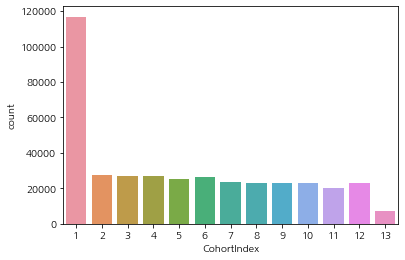

In [36]:
sns.countplot(data=df_valid, x='CohortIndex')

- 최초 구매월로부터 몇개월 경과되었을때 각각의 구매건수를 구했다. 
- 첫달 구매 후, 다음달부터 구매가 크게 줄어들고 특히 1년 경과시 더욱 크게 줄어들고 있다. 

---
#### 월별 잔존고객수 구하기 
- 첫 구매년월(InvoiceFirstDateYM)을 구한다. 
- 첫 구매년월과 CohortIndex로 그룹화 한다. 
---

In [37]:
## InvoiceDateFirst는 2011-01-18 10:01:00과 같은 형태 
## 문자열로 전환하고 앞부분 7글자만 추출하여 InvoiceDateFirst YM을 만든다. 
df_valid['InvoiceDateFirstYM'] = df_valid['InvoiceDateFirst'].astype(str).str[:7]
df_valid['InvoiceDateFirstYM']

0         2010-12
1         2010-12
2         2010-12
3         2010-12
4         2010-12
           ...   
392687    2011-08
392688    2011-08
392689    2011-08
392690    2011-08
392691    2011-08
Name: InvoiceDateFirstYM, Length: 392692, dtype: object

In [38]:
## groupby with InvoiceDateFirstYM, CohortIndex
## nunique() : 순 고객수(중복구매는 1명으로 간주)를 구하기 위해 
## unstack() : 피벗 테이블 형태로 변환 
df_valid.groupby(['InvoiceDateFirstYM', 'CohortIndex'])['CustomerID'].nunique().unstack()

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
InvoiceDateFirstYM,,,,,,,,,,,,,
2010-12,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='CohortIndex', ylabel='InvoiceDateFirstYM'>

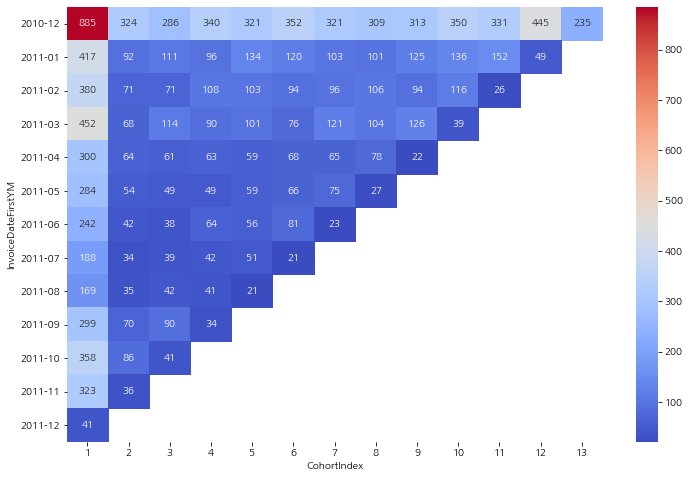

In [48]:
## heatmap 시각화 
cohort_count = df_valid.groupby(['InvoiceDateFirstYM', 'CohortIndex'])['CustomerID'].nunique().unstack()

plt.figure(figsize=(12,8))
sns.heatmap(cohort_count, cmap='coolwarm', annot=True, fmt=',.0f')

---
#### Acqusition(월별 신규유입자 수) 구하기 
- cohort_count[1] 즉 첫번째 컬럼이 각 월의 신규유입자 숫자이다. 
---

InvoiceDateFirstYM
2010-12    885.0
2011-01    417.0
2011-02    380.0
2011-03    452.0
2011-04    300.0
2011-05    284.0
2011-06    242.0
2011-07    188.0
2011-08    169.0
2011-09    299.0
2011-10    358.0
2011-11    323.0
2011-12     41.0
Name: 1, dtype: float64


<AxesSubplot:title={'center':'월별 신규유입자 수'}, xlabel='InvoiceDateFirstYM'>

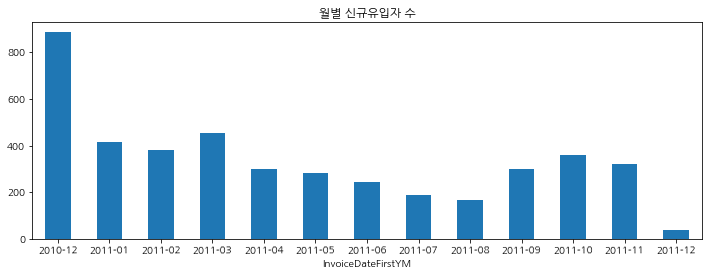

In [76]:
print(cohort_count[1])
plt.figure(figsize=(12,4))
cohort_count[1].plot(kind='bar', rot=True, title='월별 신규유입자 수')

In [74]:
## 참고. groupby가 아닌 crosstab을 이용해 잔존고객수를 구한 방식 
## - CustomerID의 중복제거에 유의 --> aggfunc = pd.Series.nunique 
cohort_count2 = pd.crosstab(df_valid['InvoiceDateFirstYM'], df_valid['CohortIndex'], 
                            values=df_valid['CustomerID'], aggfunc=pd.Series.nunique)
cohort_count2

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
InvoiceDateFirstYM,,,,,,,,,,,,,
2010-12,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---
### 월별 잔존고객 수로부터, 잔존율 구하기 
- 첫번째 달의 고객수를 분모 & 각 달의 고객수를 분자로 계산
---

In [77]:
cohort_norm = cohort_count.div(cohort_count[1], axis=0)
cohort_norm

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
InvoiceDateFirstYM,,,,,,,,,,,,,
2010-12,1.0,0.366102,0.323164,0.384181,0.362712,0.397740,0.362712,0.349153,0.353672,0.395480,0.374011,0.502825,0.265537
2011-01,1.0,0.220624,0.266187,0.230216,0.321343,0.287770,0.247002,0.242206,0.299760,0.326139,0.364508,0.117506,NaN
2011-02,1.0,0.186842,0.186842,0.284211,0.271053,0.247368,0.252632,0.278947,0.247368,0.305263,0.068421,NaN,NaN
2011-03,1.0,0.150442,0.252212,0.199115,0.223451,0.168142,0.267699,0.230088,0.278761,0.086283,NaN,NaN,NaN
2011-04,1.0,0.213333,0.203333,0.210000,0.196667,0.226667,0.216667,0.260000,0.073333,NaN,NaN,NaN,NaN
2011-05,1.0,0.190141,0.172535,0.172535,0.207746,0.232394,0.264085,0.095070,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.173554,0.157025,0.264463,0.231405,0.334711,0.095041,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.180851,0.207447,0.223404,0.271277,0.111702,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.207101,0.248521,0.242604,0.124260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='CohortIndex', ylabel='InvoiceDateFirstYM'>

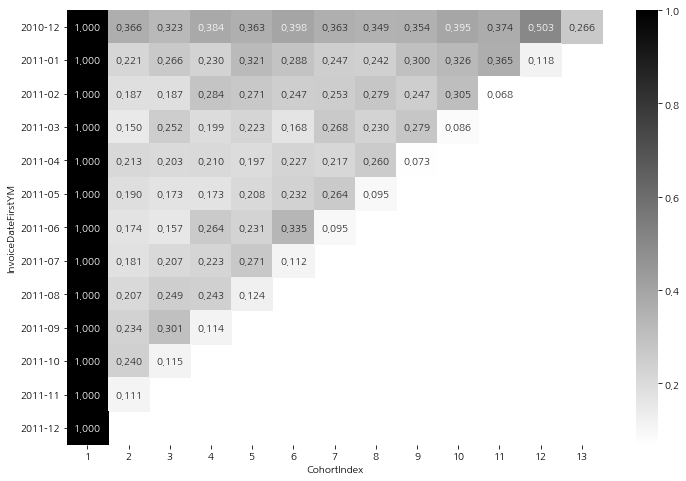

In [103]:
plt.figure(figsize=(12,8))
sns.heatmap(data=cohort_norm, cmap='gray_r', annot=True, fmt=',.3f')

---
### 매출액 관점의 월별 리텐션 구하기 
---

In [93]:
df_valid.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_price,isRegistered,...,InvoiceMonth,InvoiceDay,InvoiceDow,InvoiceTime,InvoiceHour,InvoiceYM,InvoceDayName,InvoiceDateFirst,CohortIndex,InvoiceDateFirstYM
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.3,True,...,12,1,2,08:26:00,8,2010-12,수,2010-12-01 08:26:00,1,2010-12


In [94]:
cohort_total_price = df_valid.groupby(['InvoiceDateFirstYM', 'CohortIndex'])['Total_price'].sum().unstack()
cohort_total_price

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
InvoiceDateFirstYM,,,,,,,,,,,,,
2010-12,570422.730,275734.47,233390.47,302367.44,204034.38,336113.69,313668.16,310304.03,331001.070,471792.13,455478.90,512341.08,185360.97
2011-01,292366.840,54993.86,63157.01,71526.09,80989.77,84464.57,70073.35,72503.42,71870.481,111370.70,123252.86,26388.03,NaN
2011-02,157700.590,28937.64,40964.47,48155.39,40089.17,34155.67,49673.71,62292.80,55241.340,64688.86,10600.22,NaN,NaN
2011-03,199619.670,30040.34,58958.41,42739.08,51392.44,39962.33,64824.15,70523.62,70847.620,12761.10,NaN,NaN,NaN
2011-04,121809.051,29398.59,25028.57,24282.79,26253.16,30103.24,28505.90,34009.61,6332.000,NaN,NaN,NaN,NaN
2011-05,123739.300,18641.70,20155.73,19162.17,27752.62,32875.34,33168.34,179184.23,NaN,NaN,NaN,NaN,NaN
2011-06,135414.800,14738.49,14104.37,30898.56,26669.90,42531.09,8143.22,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,73860.401,11789.67,15488.37,17391.93,19156.82,6040.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,79601.140,20933.76,35458.48,44487.65,15284.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='CohortIndex', ylabel='InvoiceDateFirstYM'>

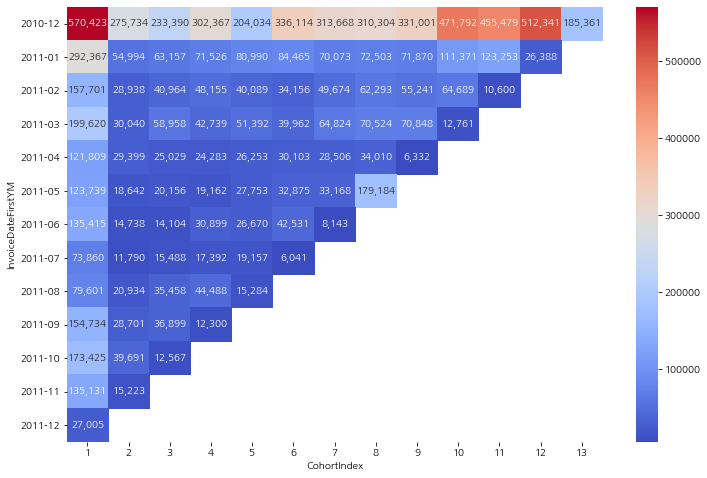

In [102]:
plt.figure(figsize=(12,8))
sns.heatmap(data = cohort_total_price, cmap='coolwarm', annot=True, fmt=',.0f')